In [1]:
#Cada columna representa un regundo de actividad del paciente.
#Cada fila representa un paciente diferente.
#La columna y es la categoria a la cual pertenece el paciente
#    5 - eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open 
#    4 - eyes closed, means when they were recording the EEG signal the patient had their eyes closed 
#    3 - Yes they identify where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area 
#    2 - They recorder the EEG from the area where the tumor was located 
#    1 - Recording of seizure activity 
#De la categoria de 2-5 son pacientes que no sufren de epilepsia, y la 1 si. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import itertools
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

/opt/miniconda/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .linbin import fast_linbin
/opt/miniconda/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:26: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  from .linbin import fast_linbin
/opt/miniconda/lib/python2.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:11: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._smoothers_lowess import lowess as _lowess
/opt/miniconda/lib/python2.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:11: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  from ._smoothers_lowess import lowess as _lowess
/opt/miniconda/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: D

In [11]:
data = pd.read_csv("Data/data.csv")
del data["Unnamed: 0"]#borrando primera columna, correspondiente a la identificación del paciente
data.head()#Visualizacion de las primeras 5 filas del dataset

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [4]:
np.sum(np.sum(data.isna())) # checking for nan values-no hay necesidad de realizar one hot encoding

0

In [5]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [6]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim != None:
        plt.ylim(*ylim)
    plt.xlabel("Training samples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Train score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score")

    plt.legend(loc="best")
    return plt


In [7]:
X = data
y = data["y"]

In [8]:
#Se utiliza lbfgs como solver porque soporta multiclase, y multinomial por la misma razón.
#Como se puede observar el accuracy de LR es muy baja, debido a que la complejidad del modelo es muy simple 
#para este tipo de clasificación.
#En la curva de aprendizaje puede observarse que al principio hay un overfitting, pero comienza a desaparecer a medida
#que se añaden datos de training.

In [8]:
def logisticRegression(X, y):
    Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=0.3)
    clf = LogisticRegression(solver='lbfgs', multi_class='multinomial')
    clf.fit(Xtr, ytr)
    predicts = clf.predict(Xts)
    acc = clf.score(Xts, yts)
    print "Logistic regression reports:\n", classification_report(yts, predicts)
    print "Logistic regression accuracy:", acc
    plot_learning_curve(clf, "Learning Curve", X, y)
    return confusion_matrix(yts, predicts)

Logistic regression reports:
             precision    recall  f1-score   support

          1       0.67      0.35      0.46       684
          2       0.16      0.03      0.05       712
          3       0.11      0.03      0.05       636
          4       0.24      0.22      0.23       713
          5       0.28      0.85      0.42       705

avg / total       0.29      0.30      0.24      3450

Logistic regression accuracy: 0.3008695652173913


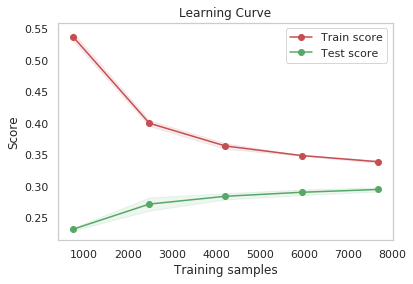

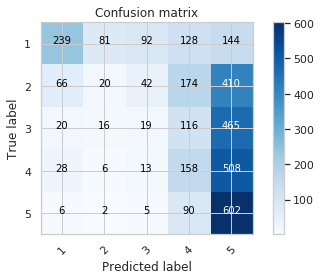

In [9]:
conf_matrix = logisticRegression(X, y)
plt.figure()
plot_confusion_matrix(conf_matrix, classes=['1', '2', '3', '4', '5'], title='Confusion matrix')
plt.show()

In [12]:
#The multiclass support is handled according to a one-vs-one scheme.
#Debido a que la complejidad de SVM en training es más que cuadrática se hace complicado aplicarlo para este dataset debido
#al tamaño de este. Por esto mismo es dificil realizar validación de parámetros, debido al tiempo de ejecución.
#Se probó con un polinomio de grado 3 y 5, pero el que mejor resultados arrojo fue de grado 2, se intentó variar
#parametros pero toma mucho tiempo para la ejecución.
#Debido a lo anterior se decidió probar con 5000 mil datos del data set para ver cómo se comportaba el algoritmo (ver imágenes)
#En la curva de aprendizaje se puede apreciar un overfitting, y a pesar de que disminuye a medida que se agregan datos de 
#train, aún así es muy grande.
#El tipo de kernel elegido fue el polinomial por el tipo de tarea de clasificación, de grado 2 porque fue le que mejor
#accuracy arrojó y el valor de gamma se decidió dejarlo auto lo que significa que es calculado como: 1 / n_features

In [34]:
def svm(X, y):
    print "calculating..."
    Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=0.2)
    clf = SVC(kernel="poly", degree=2, gamma = "auto")
    clf.fit(Xtr, ytr)
    predicts = clf.predict(Xts)
    acc = clf.score(Xts, yts)
    plot_learning_curve(clf, "Learning Curve", X, y)
    print "SVM reports:\n", classification_report(yts, predicts)
    print "SVM accuracy:", acc
    return confusion_matrix(yts, predicts)

calculating...
SVM reports:
             precision    recall  f1-score   support

          1       0.93      0.93      0.93       478
          2       0.47      0.55      0.51       429
          3       0.50      0.50      0.50       445
          4       0.74      0.74      0.74       469
          5       0.66      0.56      0.61       479

avg / total       0.67      0.66      0.66      2300

SVM accuracy: 0.66


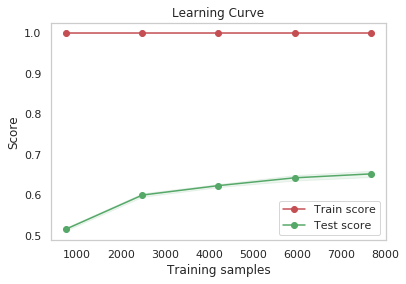

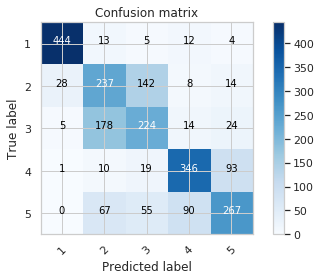

In [35]:
conf_matrix = svm(X, y)
plt.figure()
plot_confusion_matrix(conf_matrix, classes=['1', '2', '3', '4', '5'], title='Confusion matrix')
plt.show()

In [ ]:
#Random Forest fue un algoritmo que tuvo un muy buen desempeño y precisión clasificando.
#A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 
#Se decidió implementarlo con una profundidad de 17 porque mostraba muy buen desempeño tanto en accuracy como en la curva
#de aprendizaje. Además, que se hizo el análisis de validación para varias profundidades y se calculó el accuracy para cada uno(ver gráfico)
#En la curva de aprendizaje puede apreciarse un overfitting pero este disminuye a medida que se aumentan los datos de train.

In [10]:
def changeValuesRandomForest(X, y):
    print "Calculating for multiple depths..."
    plt.figure()
    max_depths = range(1, 25)
    predicts = np.array([cross_val_score(RandomForestClassifier(max_depth=i), X, y, cv=5) for i in max_depths])
    plt.plot(max_depths, predicts[:,0], "o-", color="green", label="Test")
    plt.grid()
    plt.xlabel("Random Forest max depth")
    plt.ylabel("Accuracy")

In [54]:
def randomForest(X, y):
    print "calculating..."
    Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=0.3)
    clf = RandomForestClassifier(max_depth=17)
    clf.fit(Xtr, ytr)
    predicts = clf.predict(Xts)
    acc = clf.score(Xts, yts)
    plot_learning_curve(clf, "Learning Curve", X, y)
    print "Random Forest reports:\n", classification_report(yts, predicts)
    print "Random Forest accuracy:", acc
    return confusion_matrix(yts, predicts)

calculating...
Random Forest reports:
             precision    recall  f1-score   support

          1       0.95      0.96      0.95       692
          2       0.95      0.93      0.94       734
          3       0.97      0.96      0.97       682
          4       0.98      1.00      0.99       670
          5       1.00      1.00      1.00       672

avg / total       0.97      0.97      0.97      3450

Random Forest accuracy: 0.9692753623188406


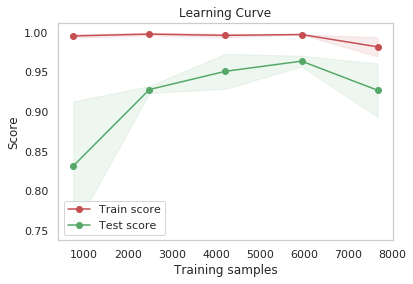

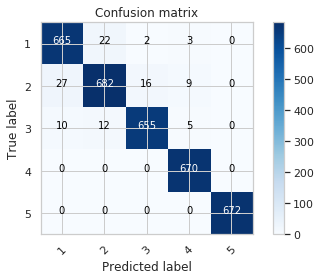

In [55]:
conf_matrix = randomForest(X, y)
plt.figure()
plot_confusion_matrix(conf_matrix, classes=['1', '2', '3', '4', '5'], title='Confusion matrix')
plt.show()

Calculating for multiple depths...


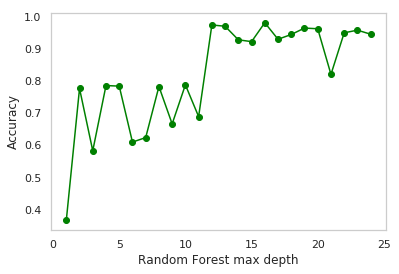

In [13]:
changeValuesRandomForest(X, y)
plt.show()

In [ ]:
#The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.
#Decision Tree es un algoritmo que tuvo un resultado perfecto en la clasificación.
#Se decidió implementarlo con una profundidad de 4 porque mostraba muy buen desempeño tanto en accuracy como en la curva
#de aprendizaje. Además, que se hizo el análisis de validación para varias profundidades y se calculó el accuracy para cada uno(ver gráfico)
#En la curva de aprendizaje se puede apreciar que no hay overfitting y prácticamente no hay varianza alguna.
#El algoritmo se desempeña muy bien en esta tarea.

In [14]:
def changeValuesDecisionTree(X, y):
    print "Calculating for multiple depths..."
    plt.figure()
    max_depths = range(1, 25)
    predicts = np.array([cross_val_score(DecisionTreeClassifier(max_depth=i), X, y, cv=5) for i in max_depths])
    plt.plot(max_depths, predicts[:,0], "o-", color="green", label="Test")
    plt.grid()
    plt.xlabel("Decision tree max depth")
    plt.ylabel("Accuracy")


In [15]:
def decisionTree(X, y):
    print "calculating..."
    Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=0.3)
    clf = DecisionTreeClassifier(max_depth=4);
    clf.fit(Xtr, ytr)
    predicts = clf.predict(Xts)
    acc = clf.score(Xts, yts)
    plot_learning_curve(clf, "Learning Curve", X, y)
    print "Decision tree reports:\n", classification_report(yts, predicts)
    print "Decision tree accuracy:", acc
    return confusion_matrix(yts, predicts)

calculating...
Decision tree reports:
             precision    recall  f1-score   support

          1       1.00      1.00      1.00       669
          2       1.00      1.00      1.00       707
          3       1.00      1.00      1.00       680
          4       1.00      1.00      1.00       696
          5       1.00      1.00      1.00       698

avg / total       1.00      1.00      1.00      3450

Decision tree accuracy: 1.0


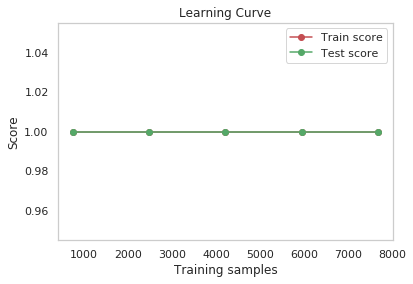

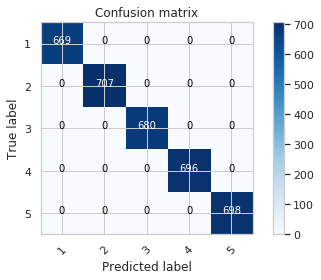

In [16]:
conf_matrix = decisionTree(X, y)
plt.figure()
plot_confusion_matrix(conf_matrix, classes=['1', '2', '3', '4', '5'], title='Confusion matrix')
plt.show()

Calculating for multiple depths...


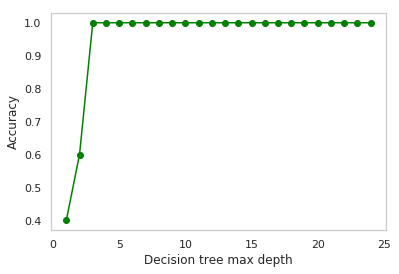

In [17]:
changeValuesDecisionTree(X, y)
plt.show()

In [19]:
#Classifier implementing the k-nearest neighbors vote.
#Cabe destacar que se recomiendan vecinos impares para evitar un empate al momento de decidir la clase.
#Este algoritmo no tuvo muy buen desempeño en esta tarea. Además que el tiempo que toma para ejecutar también es considerablemente
#alto.
#Se decide implementarlo con 23 vecinos porque en la validación se encontró que era un número con el cual el overfitting 
#disminuia, sin embargo, se pierde accuracy.
#Si se aumenta el número de vecinos se reduce el overfitting pero se pierde accuracy(ver imagen)
#La curva de aprendizaje muestra un comportamiento creciente respecto al score en train y test a medida que aumentan los
#datos de train. No se aprecia un overfitting significante. 

In [18]:
def changeValuesKNN(X, y):
    print "This might take several minutes, please be patience."
    print "Calculating for multiple neighbors..."
    plt.figure()
    num_neighbors = range(1, 25, 2)
    predicts = np.array([cross_val_score(KNeighborsClassifier(n_neighbors=i), X, y, cv=5) for i in num_neighbors])
    plt.plot(num_neighbors, predicts[:,0], "o-", color="green", label="Test")
    plt.grid()
    plt.xlabel("KNN neighbors")
    plt.ylabel("Accuracy")

In [23]:
def knn(X, y):
    print "calculating..."
    Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=0.2)
    clf = KNeighborsClassifier(n_neighbors=23);
    clf.fit(Xtr, ytr)
    predicts = clf.predict(Xts)
    acc = clf.score(Xts, yts)
    plot_learning_curve(clf, "Learning Curve", X, y)
    print "KNN reports:\n", classification_report(yts, predicts)
    print "KNN accuracy:", acc
    return confusion_matrix(yts, predicts)

calculating...
KNN reports:
             precision    recall  f1-score   support

          1       0.99      0.60      0.75       454
          2       0.30      0.52      0.38       439
          3       0.31      0.64      0.42       469
          4       0.85      0.23      0.37       445
          5       0.25      0.09      0.13       493

avg / total       0.54      0.41      0.40      2300

KNN accuracy: 0.4121739130434783


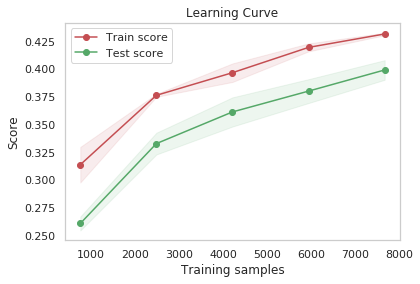

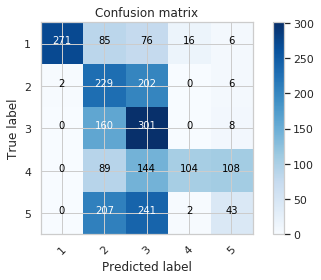

In [24]:
conf_matrix = knn(X, y)
plt.figure()
plot_confusion_matrix(conf_matrix, classes=['1', '2', '3', '4', '5'], title='Confusion matrix')
plt.show()

This might take several minutes, please be patience.
Calculating for multiple neighbors...


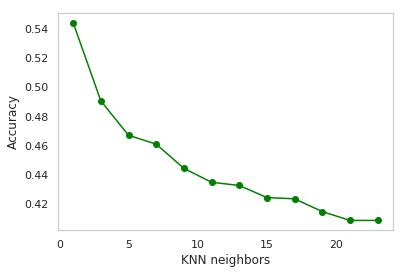

In [25]:
changeValuesKNN(X, y)
plt.show()